<img src="https://storage.googleapis.com/kaggle-datasets-images/738/1370/0a1267f68de353bec843f056c8343009/dataset-cover.jpg" width="750">

El Glass Identification Dataset es un conjunto de datos que ha sido utilizado en múltiples estudios relacionados con la clasificación y el reconocimiento de patrones. El conjunto de datos consta de 9 características que describen la composición química del vidrio, además de un identificador de tipo de vidrio. Los atributos son:

RI: Índice de refracción \
Na: Concentración de sodio (en porcentaje en peso)\
Mg: Concentración de magnesio\
Al: Concentración de aluminio\
Si: Concentración de silicio\
K: Concentración de potasio\
Ca: Concentración de calcio\
Ba: Concentración de bario\
Fe: Concentración de hierro

\
El objetivo del dataset es clasificar los vidrios en tipos basados en su uso. Originalmente hay 7 clases, pero debido a un mala desequilibrada adquisición de los datos, pueden aparecer menos. Las clases son:

1: Building windows (ventanas de edificios) - float processed\
2: Building windows (ventanas de edificios) - non-float processed\
3: Vehicle windows (ventanas de vehículos) - float processed\
4: No se usa en el dataset.\
5: Containers (contenedores)\
6: Tableware (artículos de mesa)\
7: Headlamps (faros)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset:

In [2]:
df = pd.read_csv("glass.csv")
df.sample(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
183,1.51969,14.56,0.00,0.56,73.48,0.00,11.22,0.0,0.00,6
154,1.51694,12.86,3.58,1.31,72.61,0.61,8.79,0.0,0.00,3
74,1.51596,13.02,3.56,1.54,73.11,0.72,7.90,0.0,0.00,2
86,1.51569,13.24,3.49,1.47,73.25,0.38,8.03,0.0,0.00,2
143,1.51709,13.00,3.47,1.79,72.72,0.66,8.18,0.0,0.00,2
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
85,1.51625,13.36,3.58,1.49,72.72,0.45,8.21,0.0,0.00,2
88,1.51618,13.01,3.50,1.48,72.89,0.60,8.12,0.0,0.00,2
95,1.51860,13.36,3.43,1.43,72.26,0.51,8.60,0.0,0.00,2
148,1.51670,13.24,3.57,1.38,72.70,0.56,8.44,0.0,0.10,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


## Análisis exploratorio:

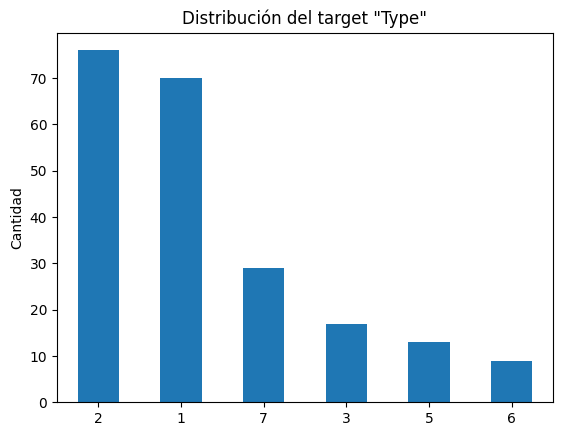

In [4]:
df['Type'].value_counts().plot(kind='bar')
plt.title('Distribución del target "Type"')
plt.xticks(rotation=0)
plt.ylabel('Cantidad')
plt.show()

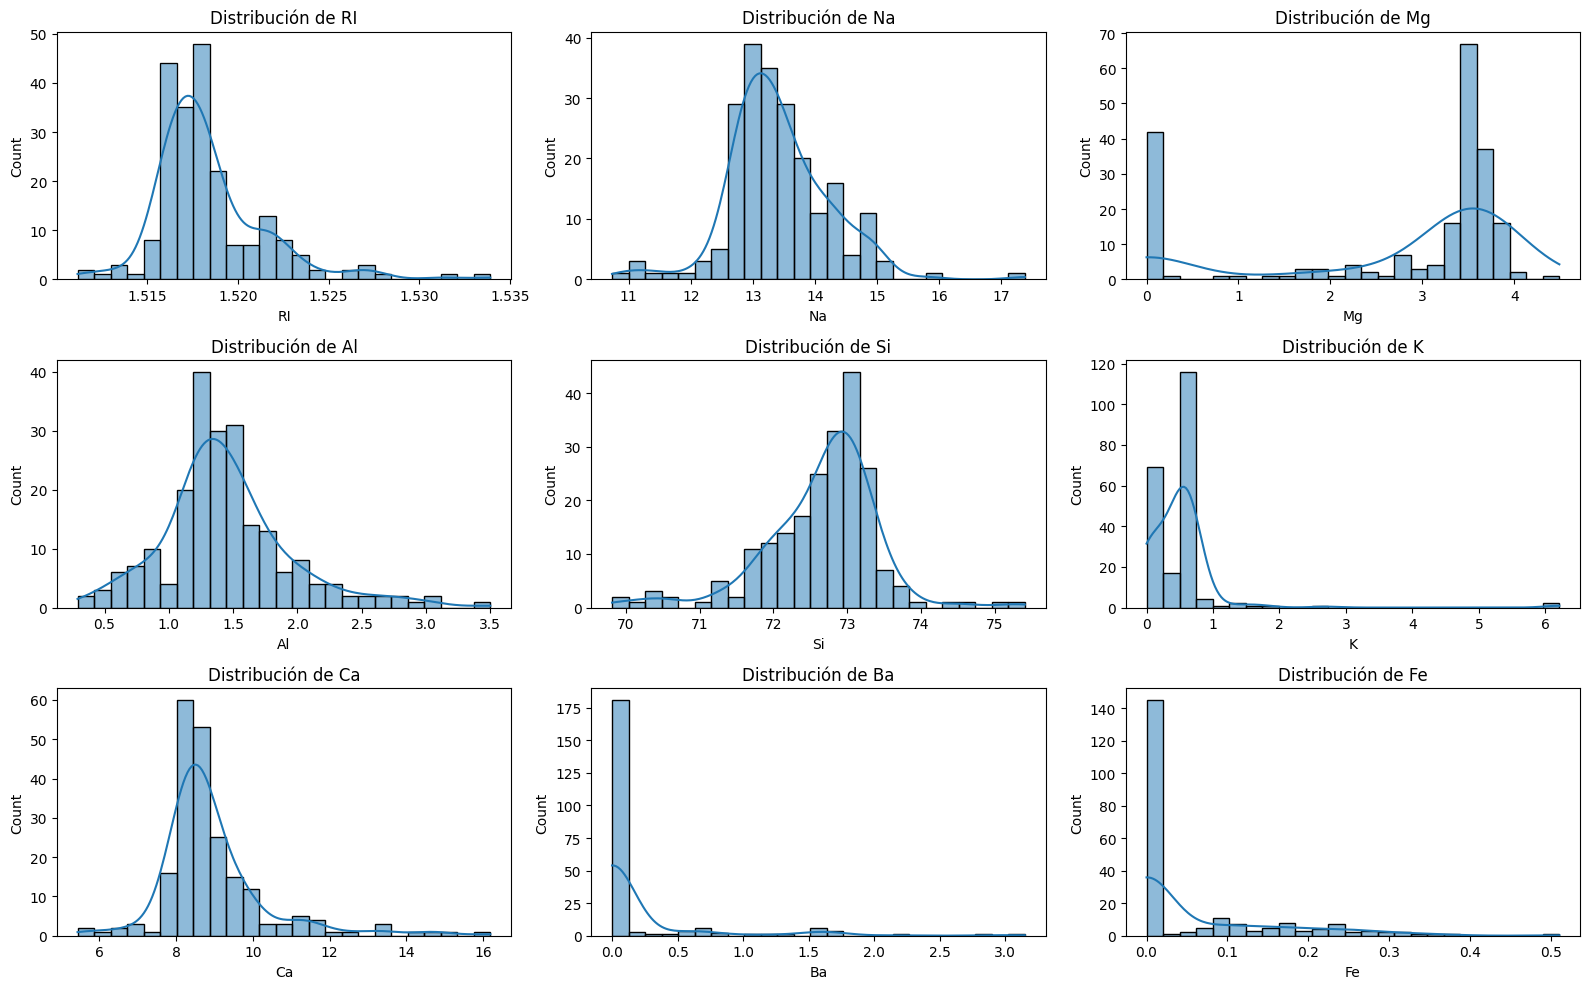

In [5]:
features = list(df.columns)
features.remove("Type")

plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], bins=25, kde=True)
    plt.title(f'Distribución de {feature}')
    plt.tight_layout()

plt.show()

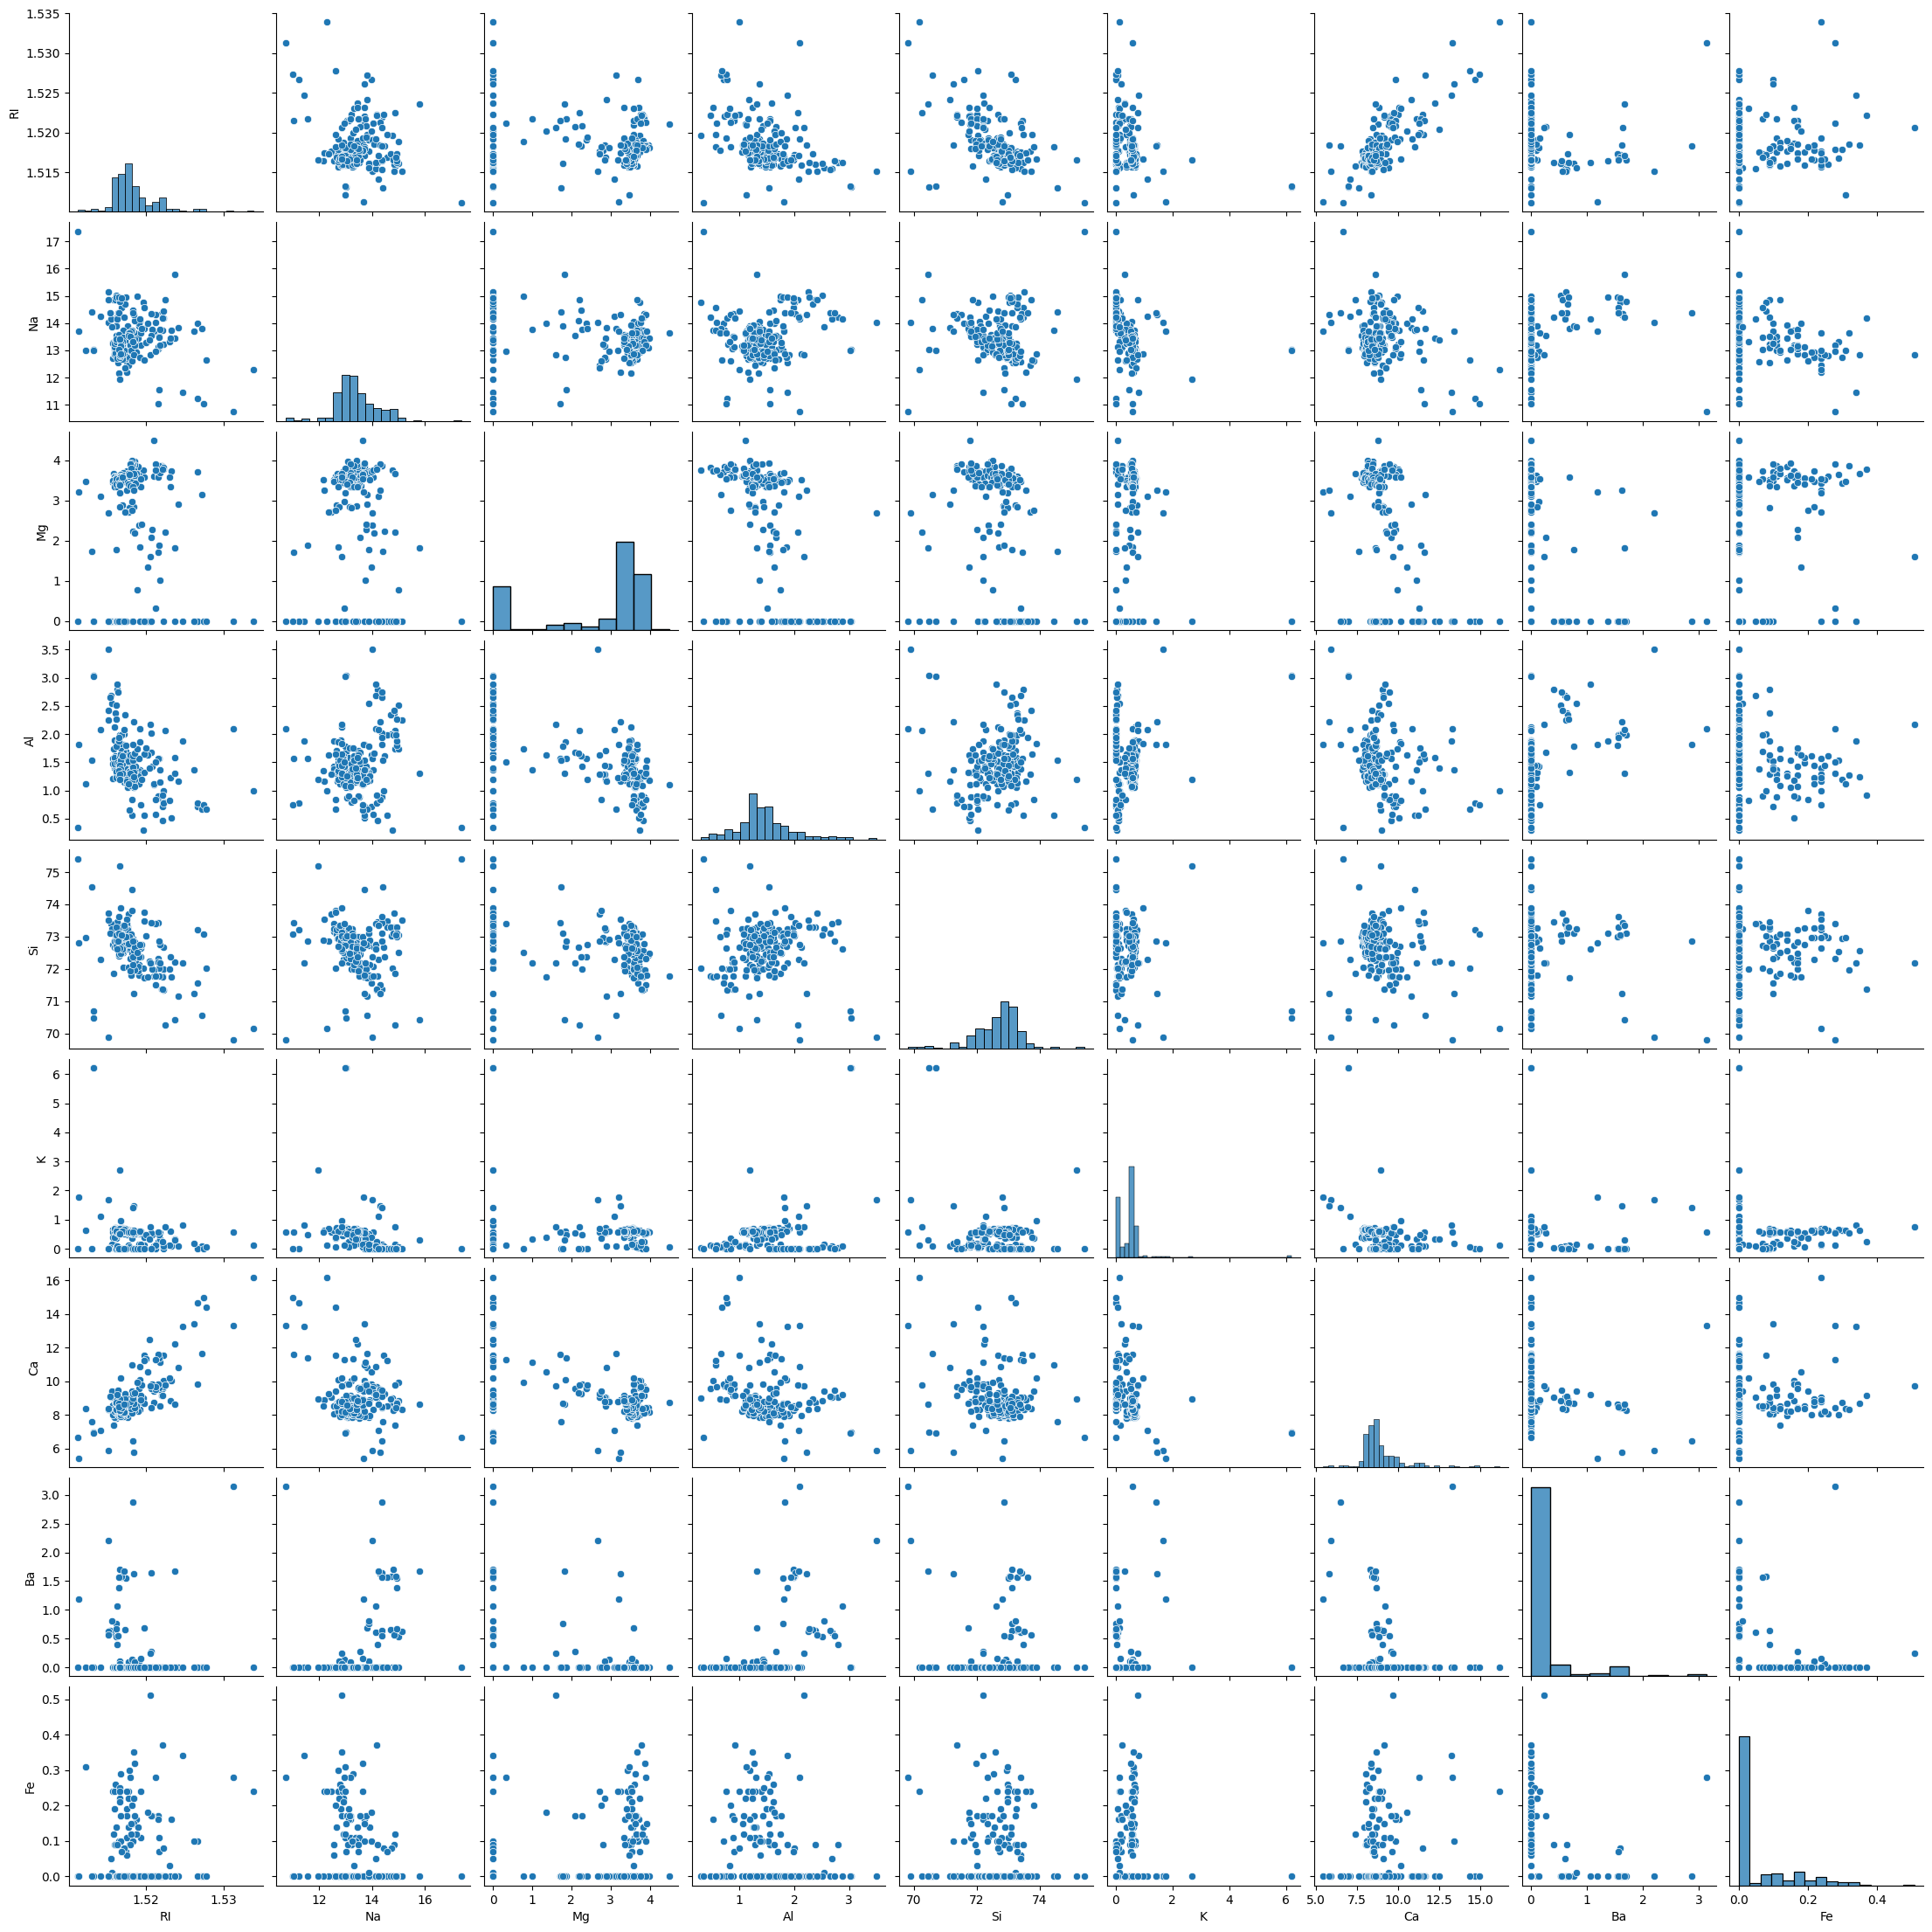

In [6]:
sns.pairplot(df[features])
plt.show()

## Preprocesamiento de los datos

Realizamos el escalamiento de los datos y analizamos si en necesario hacer un remuestreo. Recuerdamos que por más que a simple vista parezca que sí es necesario, de igual manera debemos verificar si realmente este remuestreo mejora los resultados en comparación al dataset original sin remuestreo, así que deberemos probar con ambas alternativas.

In [7]:
X = df.drop('Type', axis=1)
y = df["Type"]

#### Escalamiento:

In [8]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(data_scaled, columns=X.columns)
df_scaled['Type'] = y
df_scaled.sample(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
170,1.757426,0.039462,-1.865511,0.271217,-0.557675,-0.272115,2.312284,-0.352877,-0.586451,5
100,-0.599196,-0.807482,0.114985,-0.009850,0.801137,0.112107,-0.117594,-0.131128,1.676673,2
43,1.232632,0.395424,0.802947,-1.455338,-1.152964,-0.502648,0.551503,-0.352877,-0.586451,1
99,-0.084304,-0.549717,0.191425,-0.029927,0.348199,0.158213,-0.117594,-0.070651,-0.586451,2
201,-0.605797,-1.789447,-1.865511,-0.511756,3.272880,3.385674,-0.018990,-0.352877,-0.586451,7
82,-0.628901,0.002638,0.601422,-0.391299,0.205848,0.281164,-0.603569,-0.352877,-0.586451,2
121,-0.572791,-0.586540,0.594473,0.351521,0.399964,0.219689,-0.652871,-0.352877,1.573803,2
133,-0.120610,0.370875,0.865489,0.190912,-1.088259,0.066000,-0.526095,-0.352877,0.956588,2
113,0.183044,0.064011,0.795997,-0.371222,-0.130620,0.112107,-0.526095,-0.352877,0.853719,2
77,-0.691613,-0.500618,0.622270,0.190912,0.231730,0.173582,-0.645828,-0.352877,-0.586451,2


In [9]:
X = df_scaled.drop('Type', axis=1)
y = df_scaled["Type"]

#### Remuestreo:

In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

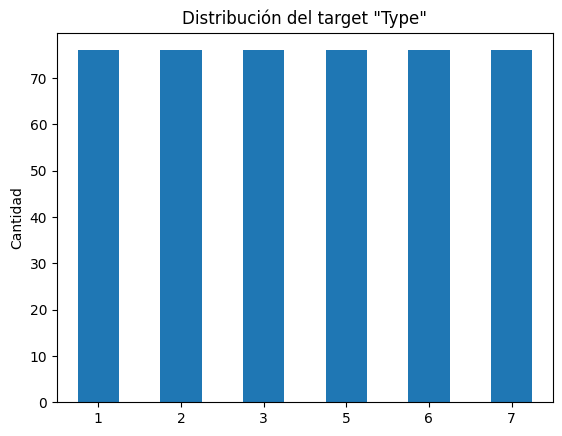

In [11]:
y_resampled.value_counts().plot(kind='bar')
plt.title('Distribución del target "Type"')
plt.xticks(rotation=0)
plt.ylabel('Cantidad')
plt.show()

## Modelos de clasificación

Para este apartado, armamos en un inicio 3 dataset diferentes, uno será el dataset original, luego un PCA de 3 componentes y luego uno de 2 componentes, para cada modelo planteado hacemos los 3 entrenamientos y finalmente los comparamos. También sacamos las métricas de desempeño, tanto las que son numéricas como las que son gráficas, recordamos que puede que para uno u otro modelo se deba sacar una métrica adicional propia del modelo. Al final de todo, en un dataframe hacemos un resumen de las métricas de desempeño obtenidas (principalmente f1) comparando cada modelo y cada dataset utilizado. Al momento de comparar, procuramos que cada modelo utilice el hiperparámetro que mejor desempeño le dé.

#### Definimos los 3 conjuntos de datos:

In [12]:
# Data "original" preprocesada
df_resampled = pd.DataFrame(X_resampled, columns=X.columns).copy()
df_resampled['Type'] = y_resampled

# PCA 3 componentes
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_resampled)

# PCA 2 componentes
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_resampled)

### Modelos para la data "original":

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

#### Árbol de decisión:

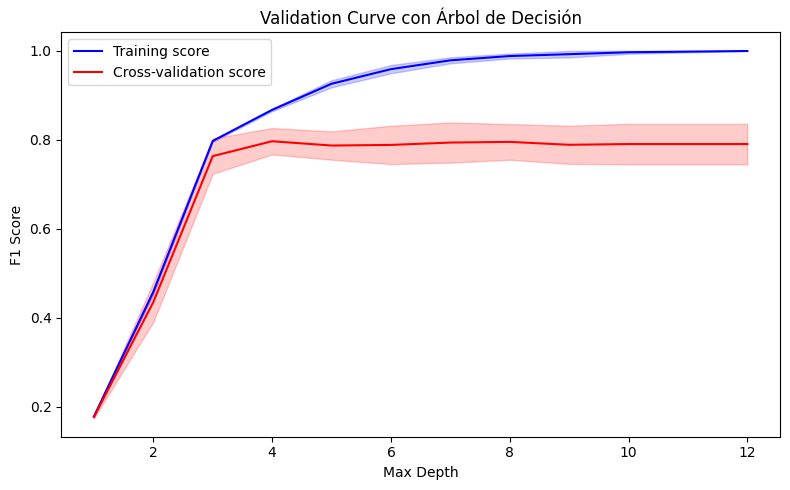

In [14]:
param_range = np.arange(1, 13)

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con Árbol de Decisión")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Observamos que el mayor valor de f1 para cross-validation se obtiene con una profundidad de 4 capas, entonces ese será el valor que elegiremos:

In [15]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt}")

Accuracy: 0.8070175438596491


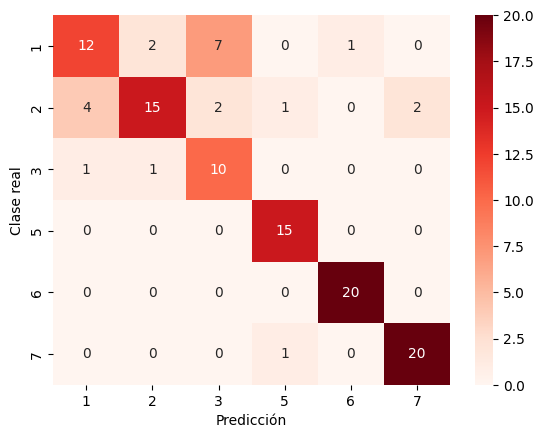

In [16]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [17]:
print(classification_rep_dt)

              precision    recall  f1-score   support

           1       0.71      0.55      0.62        22
           2       0.83      0.62      0.71        24
           3       0.53      0.83      0.65        12
           5       0.88      1.00      0.94        15
           6       0.95      1.00      0.98        20
           7       0.91      0.95      0.93        21

    accuracy                           0.81       114
   macro avg       0.80      0.83      0.80       114
weighted avg       0.82      0.81      0.80       114



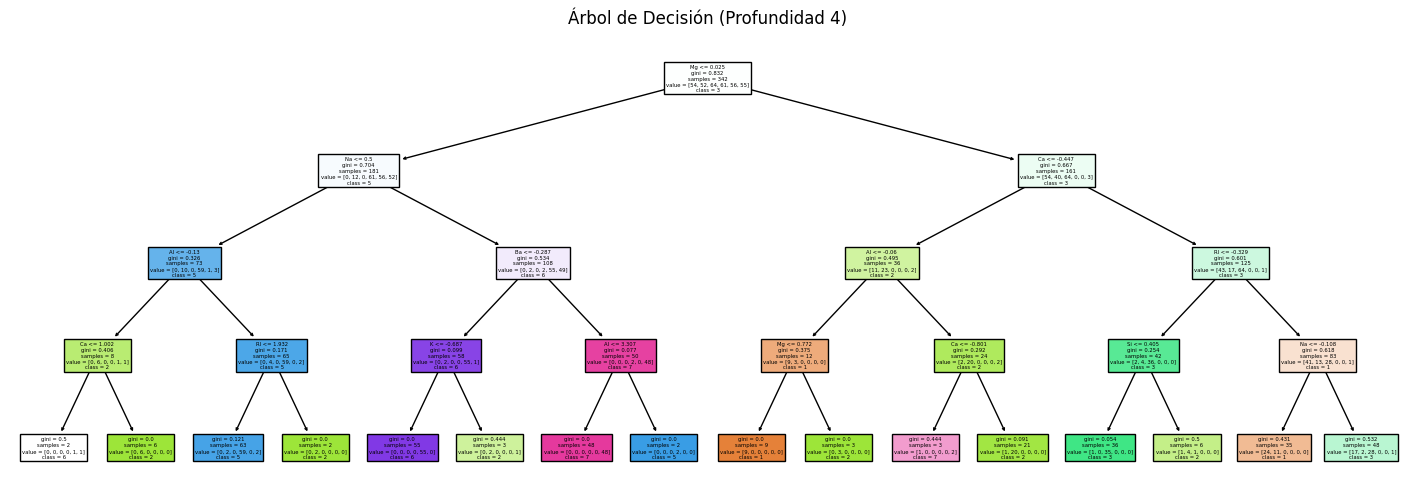

In [18]:
plt.figure(figsize=(18, 6))
plot_tree(dt, filled=True, feature_names=df_resampled.columns, class_names=['1', '2', '3', '5', '6', '7'])
plt.title("Árbol de Decisión (Profundidad 4)")
plt.show()

#### Random forest:

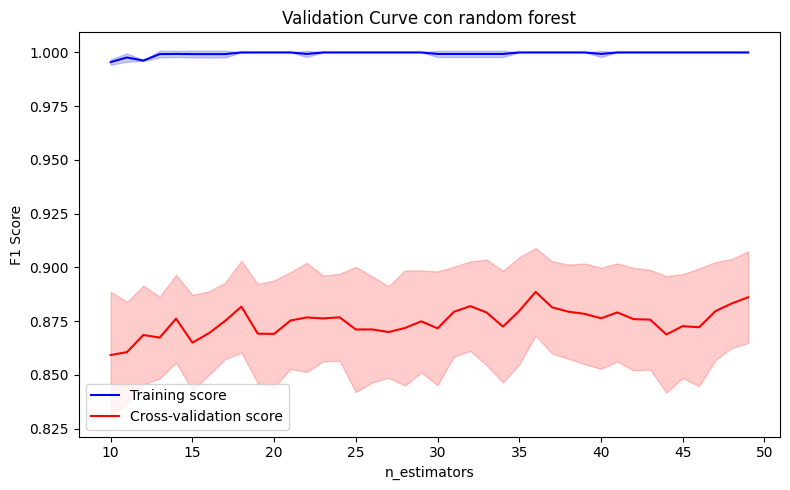

In [19]:
param_range = np.arange(10, 50)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con random forest")
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Observamos que el mayor valor de f1 para cross-validation se obtiene con un bosque de 37 árboles (estimadores), entonces ese será el valor que elegiremos:

In [20]:
rf = RandomForestClassifier(n_estimators=37, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.9210526315789473


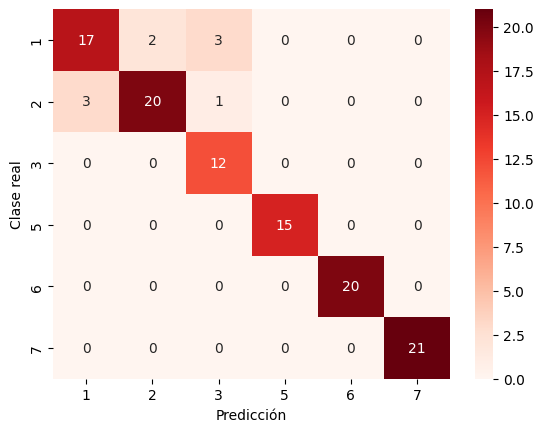

In [21]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", fmt="d", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [22]:
print(classification_rep_rf)

              precision    recall  f1-score   support

           1       0.85      0.77      0.81        22
           2       0.91      0.83      0.87        24
           3       0.75      1.00      0.86        12
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        21

    accuracy                           0.92       114
   macro avg       0.92      0.93      0.92       114
weighted avg       0.93      0.92      0.92       114



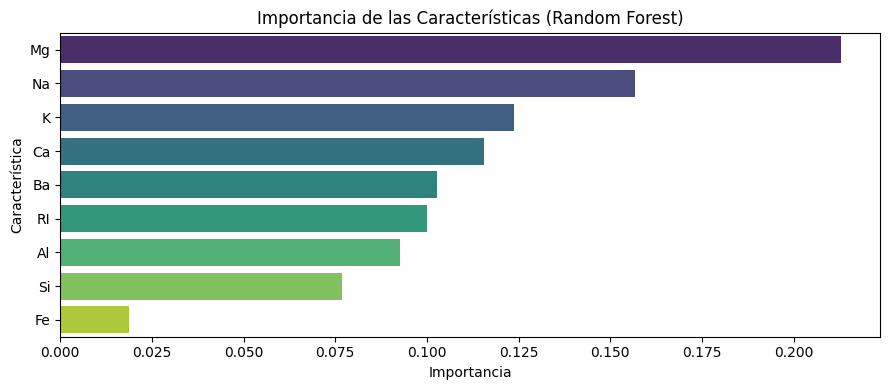

In [23]:
feature_importances_rf = rf.feature_importances_

features_rf_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances_rf
})

features_rf_df = features_rf_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(9, 4))
sns.barplot(x='Importance', y='Feature', data=features_rf_df, palette='viridis')
plt.title('Importancia de las Características (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

#### K-NN:

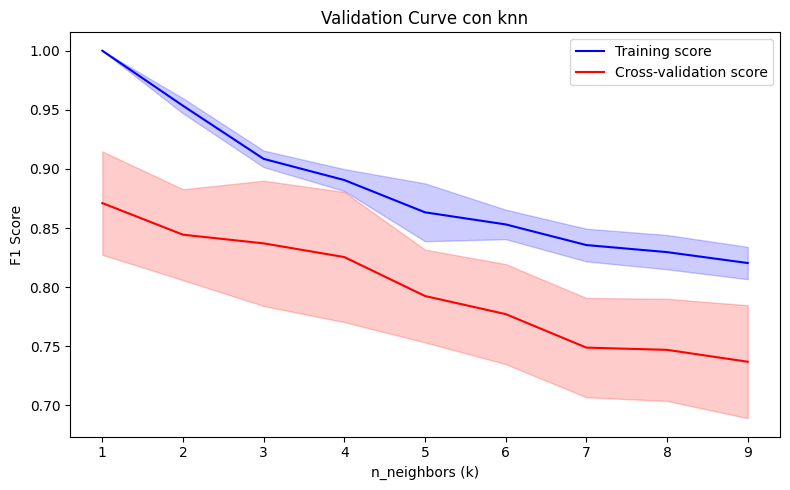

In [24]:
param_range = np.arange(1, 10)

train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train, y_train,
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con knn")
plt.xlabel("n_neighbors (k)")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Observamos que el mayor valor de f1 para cross-validation se obtiene con un k de 1 (vecino), entonces ese será el valor que elegiremos:

In [25]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn}")

Accuracy: 0.8771929824561403


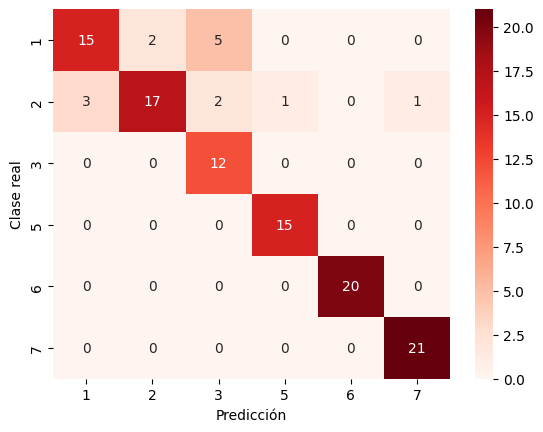

In [26]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [27]:
print(classification_rep_knn)

              precision    recall  f1-score   support

           1       0.83      0.68      0.75        22
           2       0.89      0.71      0.79        24
           3       0.63      1.00      0.77        12
           5       0.94      1.00      0.97        15
           6       1.00      1.00      1.00        20
           7       0.95      1.00      0.98        21

    accuracy                           0.88       114
   macro avg       0.88      0.90      0.88       114
weighted avg       0.89      0.88      0.88       114



#### SVM:

Elegiremos un kernel de tipo polinomial, ya que por teoría sabemos que es el más versatil

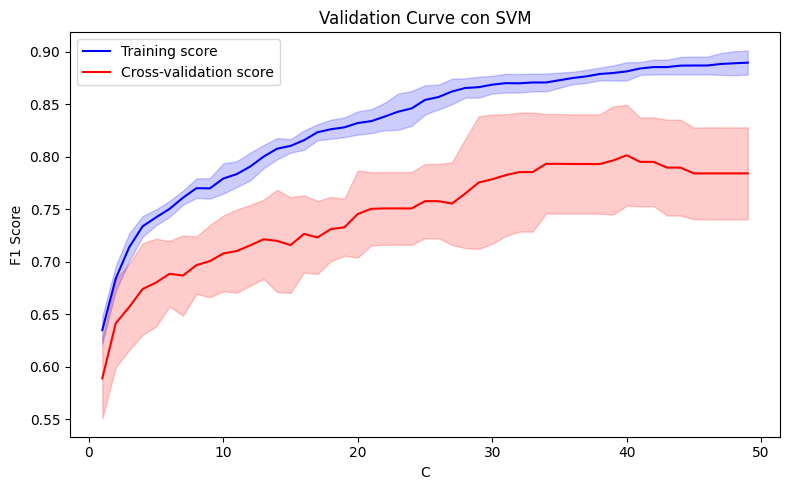

In [28]:
param_range = np.arange(1, 50)

train_scores, test_scores = validation_curve(
    SVC(kernel='poly', random_state=42),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con SVM")
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Para esta oportunidad, solo se variará el C, mientras que el gamma se quedará en su valor por defecto. Teniendo esto en cuenta, vemos que el mayor valor se encuentra cuando C vale 40, así que elegiremos ese valor:

In [29]:
from sklearn.svm import SVC
svm_model = SVC(kernel='poly', C=40, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm}")

Accuracy: 0.7982456140350878


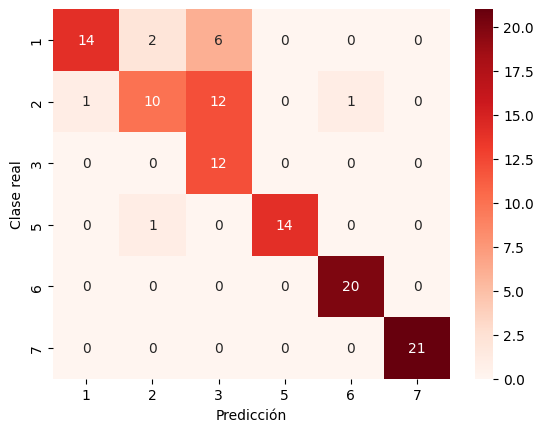

In [30]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [31]:
print(classification_rep_svm)

              precision    recall  f1-score   support

           1       0.93      0.64      0.76        22
           2       0.77      0.42      0.54        24
           3       0.40      1.00      0.57        12
           5       1.00      0.93      0.97        15
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        21

    accuracy                           0.80       114
   macro avg       0.84      0.83      0.80       114
weighted avg       0.87      0.80      0.80       114



### Modelos para la PCA 3:

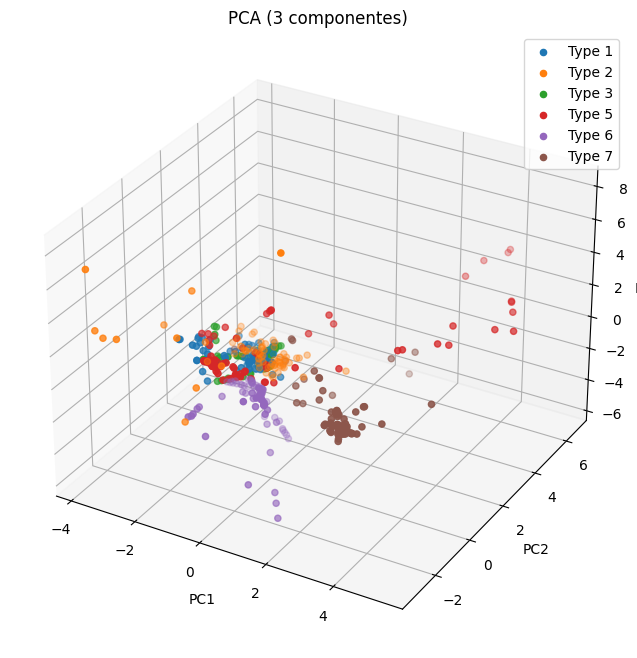

In [32]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in y_resampled.unique():
    ax.scatter(X_pca_3[y_resampled == i, 0], X_pca_3[y_resampled == i, 1], X_pca_3[y_resampled == i, 2], label=f'Type {i}')

ax.set_title('PCA (3 componentes)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

In [33]:
# Porcentaje de varianza explicada por cada componente en PCA de 3 componentes
explained_variance_ratio_3 = pca_3.explained_variance_ratio_

explained_variance_ratio_df_3 = pd.DataFrame({
    'Componente Principal': ['PC1', 'PC2', 'PC3'],
    'Varianza Explicada (%)': explained_variance_ratio_3 * 100
})

explained_variance_ratio_df_3

,Componente Principal,Varianza Explicada (%)
0,PC1,28.373050
1,PC2,21.486765
2,PC3,18.480058


In [34]:
print(f"Porcentaje de la información total recogida por los PCAs: {pca_3.explained_variance_ratio_.sum()*100:.2f}%")
print()
print(f"Se perdió un {(1-pca_3.explained_variance_ratio_.sum())*100:.2f}% de la información")

Porcentaje de la información total recogida por los PCAs: 68.34%

Se perdió un 31.66% de la información


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_3, y_resampled, test_size=0.25, random_state=42)

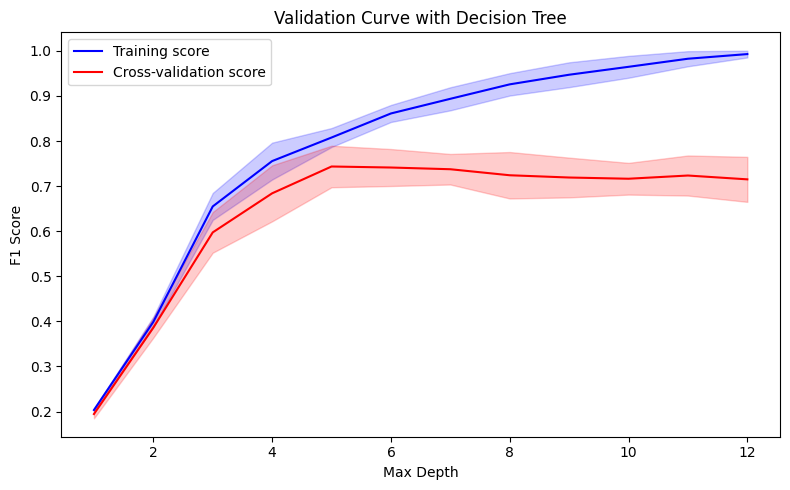

In [36]:
param_range = np.arange(1, 13)

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve with Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [37]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt}")

Accuracy: 0.7280701754385965


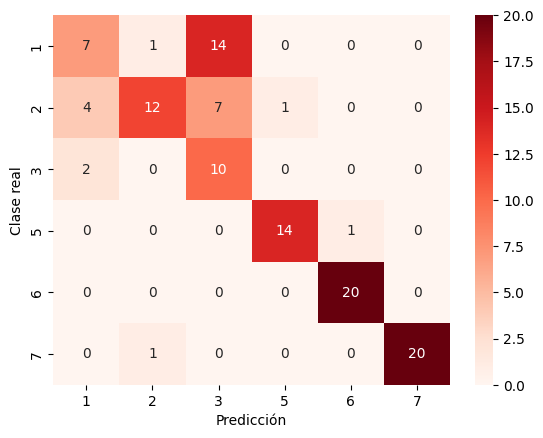

In [38]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [39]:
print(classification_rep_dt)

              precision    recall  f1-score   support

           1       0.54      0.32      0.40        22
           2       0.86      0.50      0.63        24
           3       0.32      0.83      0.47        12
           5       0.93      0.93      0.93        15
           6       0.95      1.00      0.98        20
           7       1.00      0.95      0.98        21

    accuracy                           0.73       114
   macro avg       0.77      0.76      0.73       114
weighted avg       0.79      0.73      0.73       114



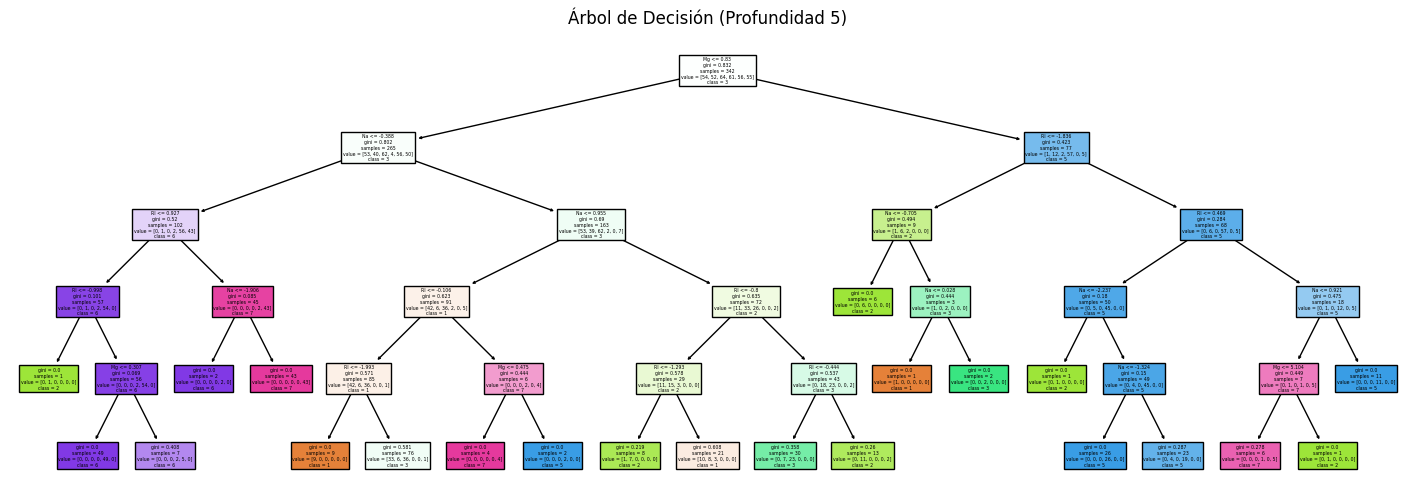

In [40]:
plt.figure(figsize=(18, 6))
plot_tree(dt, filled=True, feature_names=df_resampled.columns, class_names=['1', '2', '3', '5', '6', '7'])
plt.title("Árbol de Decisión (Profundidad 5)")
plt.show()

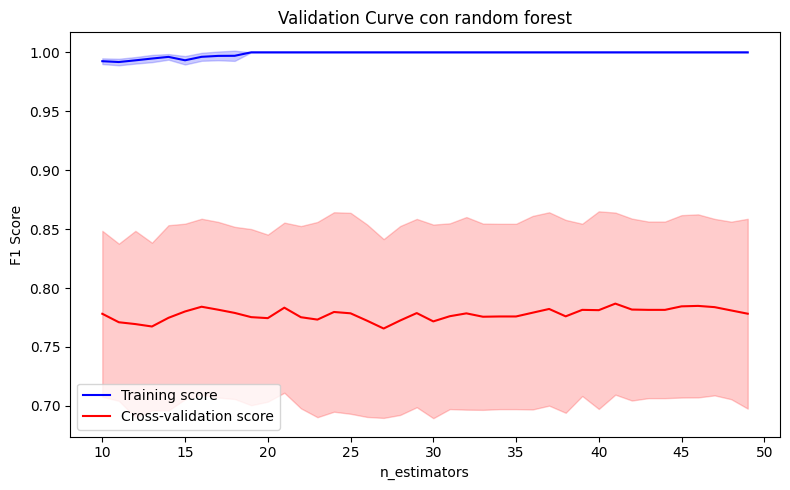

In [41]:
param_range = np.arange(10, 50)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con random forest")
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [42]:
rf = RandomForestClassifier(n_estimators=16, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.8070175438596491


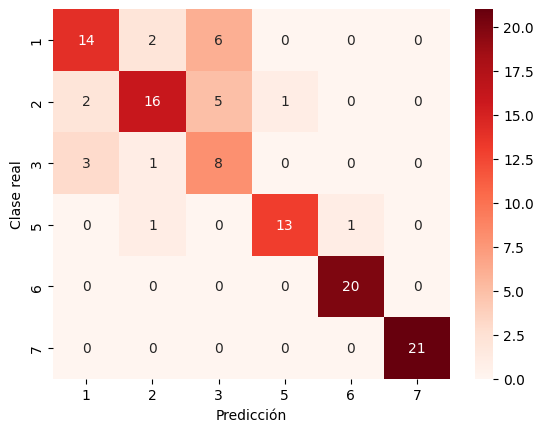

In [43]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [44]:
print(classification_rep_rf)

              precision    recall  f1-score   support

           1       0.74      0.64      0.68        22
           2       0.80      0.67      0.73        24
           3       0.42      0.67      0.52        12
           5       0.93      0.87      0.90        15
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        21

    accuracy                           0.81       114
   macro avg       0.81      0.81      0.80       114
weighted avg       0.83      0.81      0.81       114



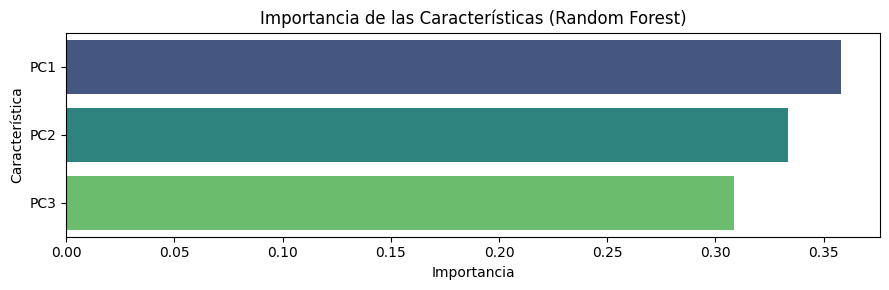

In [45]:
feature_importances_rf = rf.feature_importances_

features_rf_df = pd.DataFrame({
    'Feature': ["PC1", "PC2", "PC3"],
    'Importance': feature_importances_rf
})

features_rf_df = features_rf_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(9, 3))
sns.barplot(x='Importance', y='Feature', data=features_rf_df, palette='viridis')
plt.title('Importancia de las Características (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

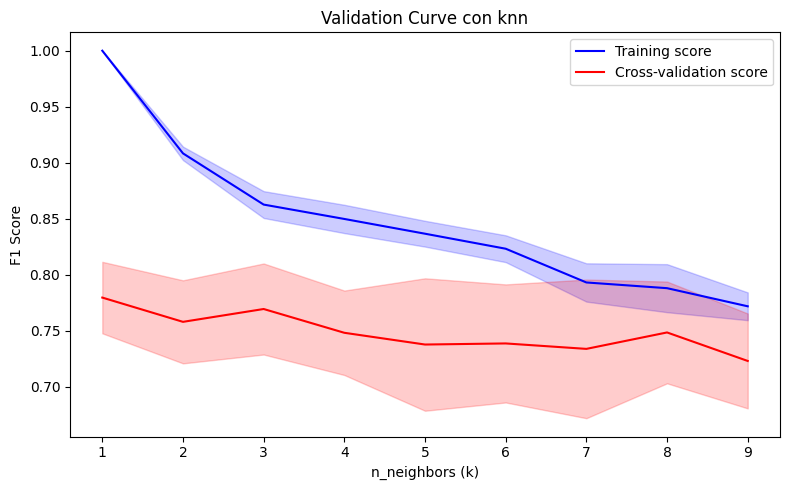

In [46]:
param_range = np.arange(1, 10)

train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train, y_train,
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con knn")
plt.xlabel("n_neighbors (k)")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [47]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn}")

Accuracy: 0.7807017543859649


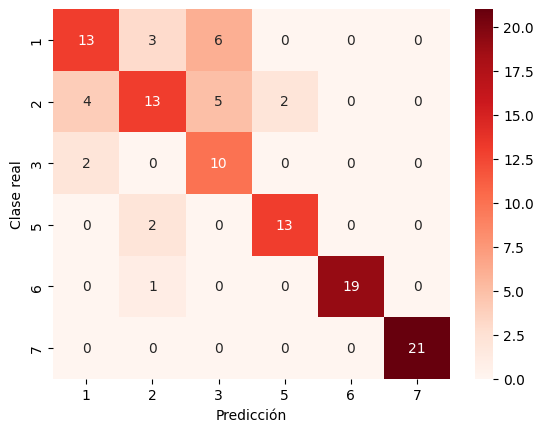

In [48]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [49]:
print(classification_rep_knn)

              precision    recall  f1-score   support

           1       0.68      0.59      0.63        22
           2       0.68      0.54      0.60        24
           3       0.48      0.83      0.61        12
           5       0.87      0.87      0.87        15
           6       1.00      0.95      0.97        20
           7       1.00      1.00      1.00        21

    accuracy                           0.78       114
   macro avg       0.79      0.80      0.78       114
weighted avg       0.80      0.78      0.78       114



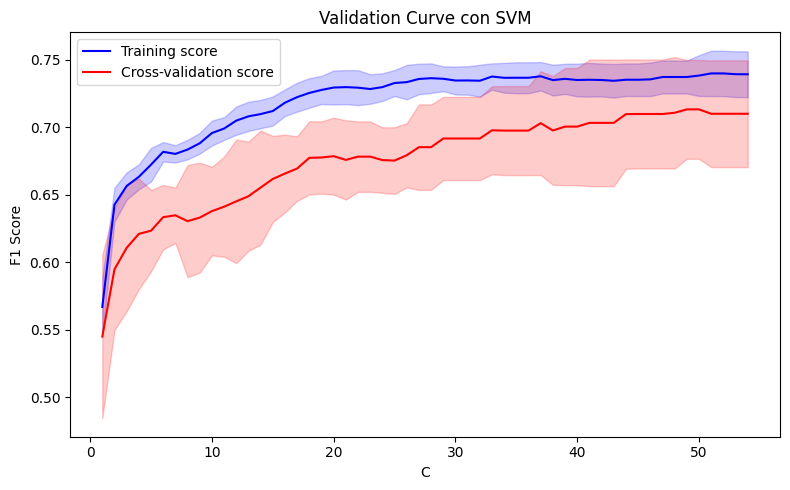

In [50]:
param_range = np.arange(1, 55)

train_scores, test_scores = validation_curve(
    SVC(kernel='poly', random_state=42),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con SVM")
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [51]:
svm_model = SVC(kernel='poly', C=49, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm}")

Accuracy: 0.6929824561403509


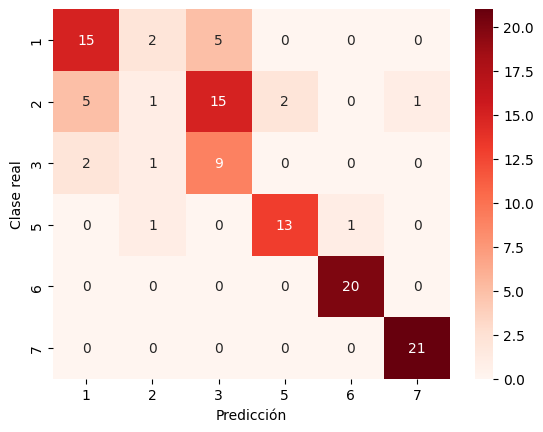

In [52]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [53]:
print(classification_rep_svm)

              precision    recall  f1-score   support

           1       0.68      0.68      0.68        22
           2       0.20      0.04      0.07        24
           3       0.31      0.75      0.44        12
           5       0.87      0.87      0.87        15
           6       0.95      1.00      0.98        20
           7       0.95      1.00      0.98        21

    accuracy                           0.69       114
   macro avg       0.66      0.72      0.67       114
weighted avg       0.66      0.69      0.66       114



### Modelos para la PCA 2:

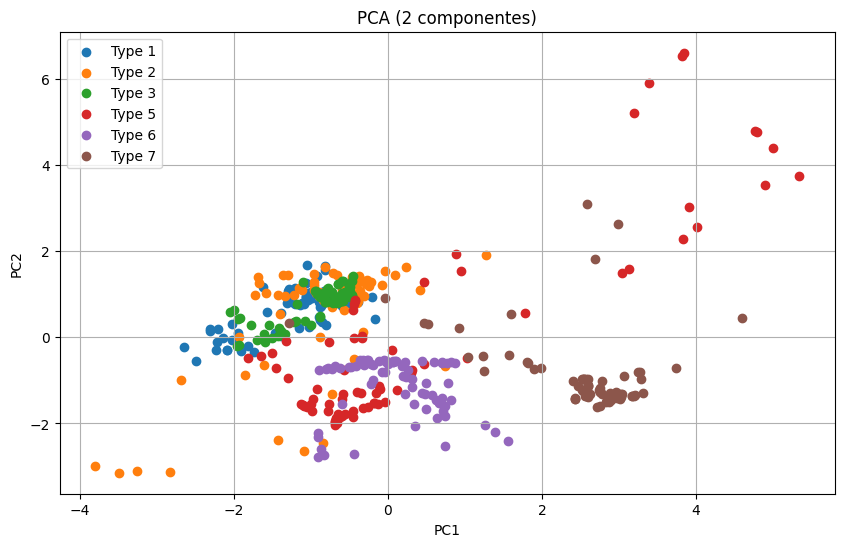

In [54]:
plt.figure(figsize=(10, 6))

for i in y_resampled.unique():
    plt.scatter(X_pca_2[y_resampled == i, 0], X_pca_2[y_resampled == i, 1], label=f'Type {i}')

plt.title('PCA (2 componentes)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Porcentaje de varianza explicada por cada componente en PCA de 2 componentes
explained_variance_ratio_2 = pca_2.explained_variance_ratio_

explained_variance_ratio_df_2 = pd.DataFrame({
    'Componente Principal': ['PC1', 'PC2'],
    'Varianza Explicada (%)': explained_variance_ratio_2 * 100
})

explained_variance_ratio_df_2

,Componente Principal,Varianza Explicada (%)
0,PC1,28.373050
1,PC2,21.486765


In [56]:
print(f"Porcentaje de la información total recogida por los PCAs: {pca_2.explained_variance_ratio_.sum()*100:.2f}%")
print()
print(f"Se perdió un {(1-pca_2.explained_variance_ratio_.sum())*100:.2f}% de la información")

Porcentaje de la información total recogida por los PCAs: 49.86%

Se perdió un 50.14% de la información


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_2, y_resampled, test_size=0.25, random_state=42)

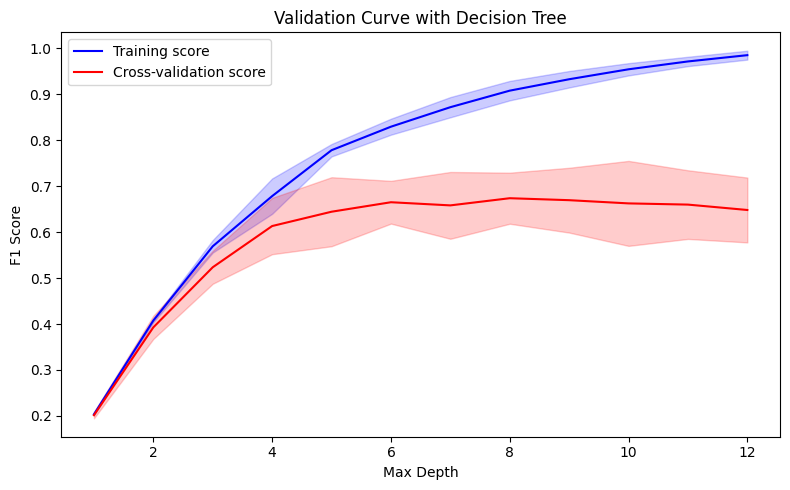

In [58]:
param_range = np.arange(1, 13)

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve with Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [59]:
dt = DecisionTreeClassifier(max_depth=8, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt}")

Accuracy: 0.7368421052631579


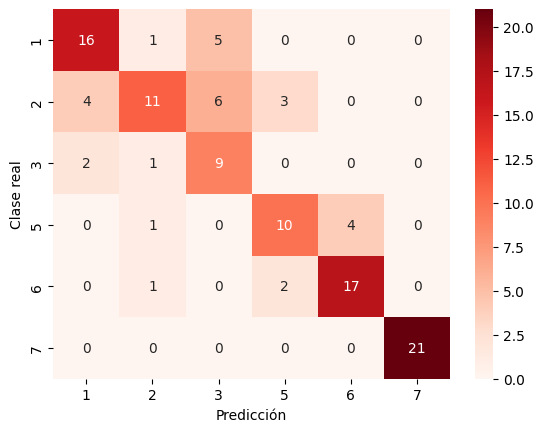

In [60]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [61]:
print(classification_rep_dt)

              precision    recall  f1-score   support

           1       0.73      0.73      0.73        22
           2       0.73      0.46      0.56        24
           3       0.45      0.75      0.56        12
           5       0.67      0.67      0.67        15
           6       0.81      0.85      0.83        20
           7       1.00      1.00      1.00        21

    accuracy                           0.74       114
   macro avg       0.73      0.74      0.72       114
weighted avg       0.76      0.74      0.74       114



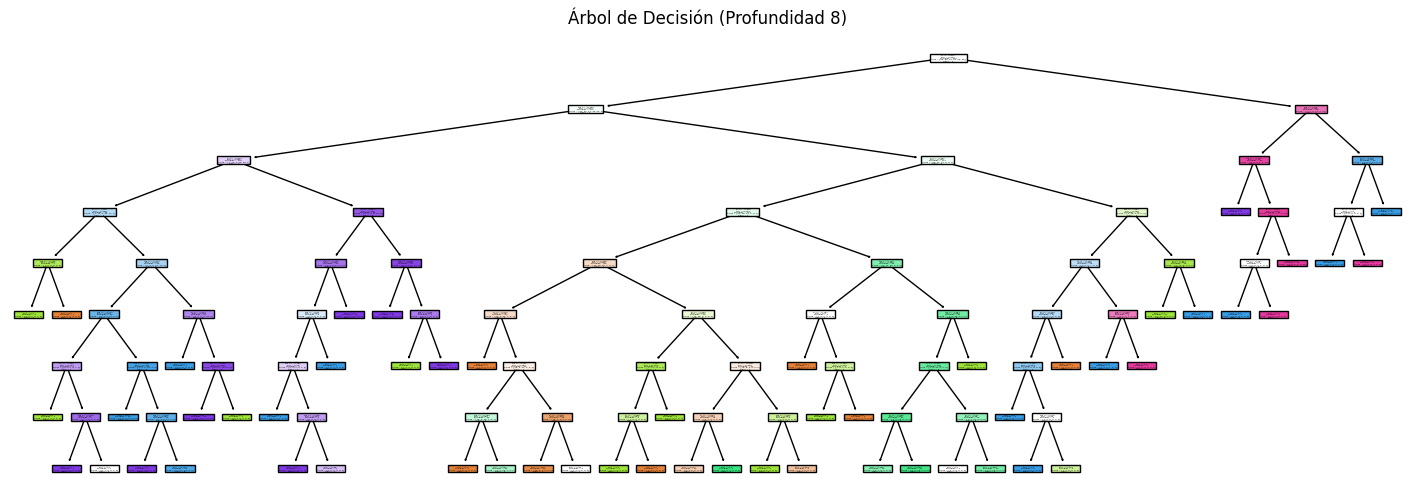

In [62]:
plt.figure(figsize=(18, 6))
plot_tree(dt, filled=True, feature_names=df_resampled.columns, class_names=['1', '2', '3', '5', '6', '7'])
plt.title("Árbol de Decisión (Profundidad 8)")
plt.show()

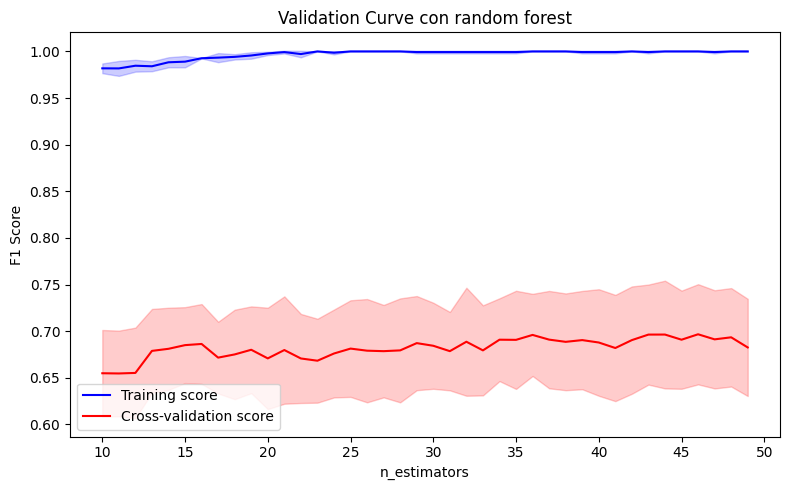

In [63]:
param_range = np.arange(10, 50)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con random forest")
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [64]:
rf = RandomForestClassifier(n_estimators=36, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.7807017543859649


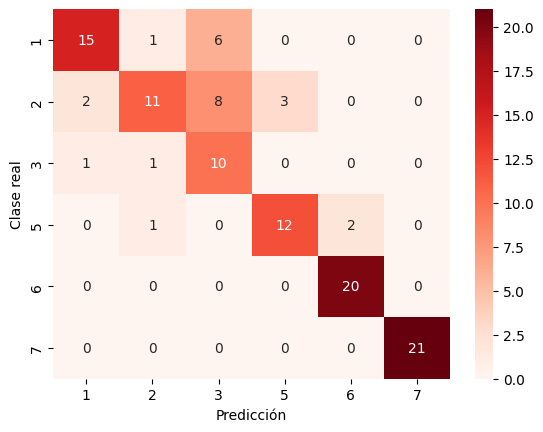

In [65]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [66]:
print(classification_rep_rf)

              precision    recall  f1-score   support

           1       0.83      0.68      0.75        22
           2       0.79      0.46      0.58        24
           3       0.42      0.83      0.56        12
           5       0.80      0.80      0.80        15
           6       0.91      1.00      0.95        20
           7       1.00      1.00      1.00        21

    accuracy                           0.78       114
   macro avg       0.79      0.80      0.77       114
weighted avg       0.82      0.78      0.78       114



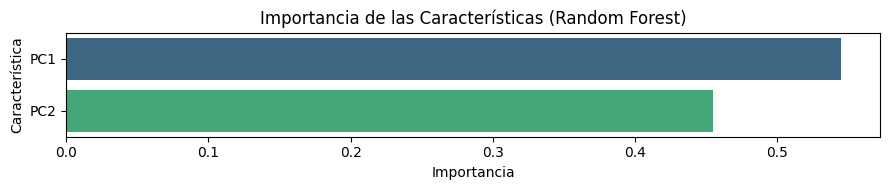

In [67]:
feature_importances_rf = rf.feature_importances_

features_rf_df = pd.DataFrame({
    'Feature': ["PC1", "PC2"],
    'Importance': feature_importances_rf
})

features_rf_df = features_rf_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(9, 2))
sns.barplot(x='Importance', y='Feature', data=features_rf_df, palette='viridis')
plt.title('Importancia de las Características (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

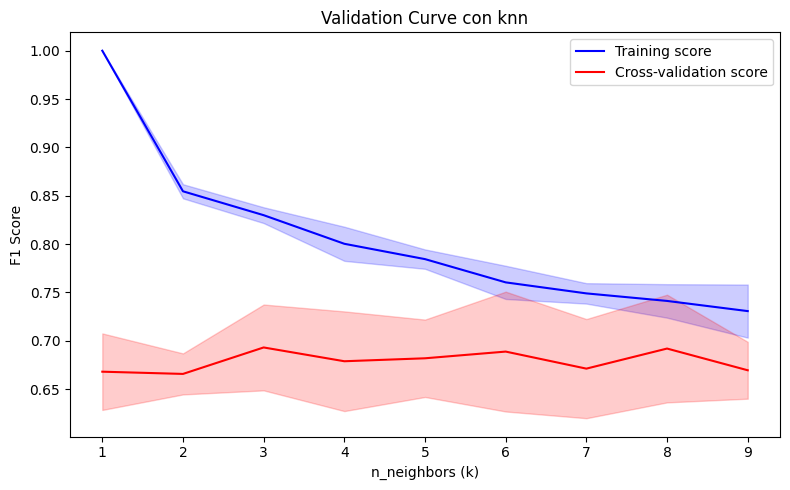

In [68]:
param_range = np.arange(1, 10)

train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train, y_train,
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con knn")
plt.xlabel("n_neighbors (k)")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [69]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn}")

Accuracy: 0.7894736842105263


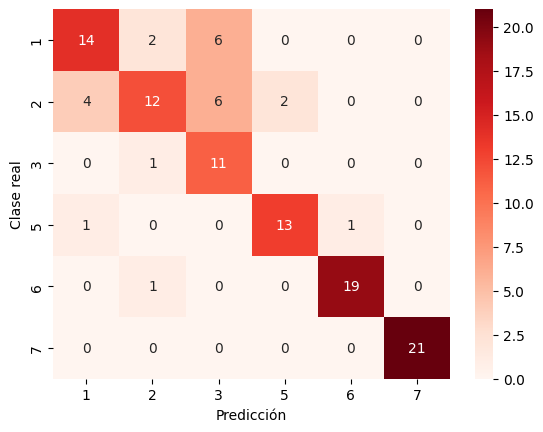

In [70]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [71]:
print(classification_rep_knn)

              precision    recall  f1-score   support

           1       0.74      0.64      0.68        22
           2       0.75      0.50      0.60        24
           3       0.48      0.92      0.63        12
           5       0.87      0.87      0.87        15
           6       0.95      0.95      0.95        20
           7       1.00      1.00      1.00        21

    accuracy                           0.79       114
   macro avg       0.80      0.81      0.79       114
weighted avg       0.82      0.79      0.79       114



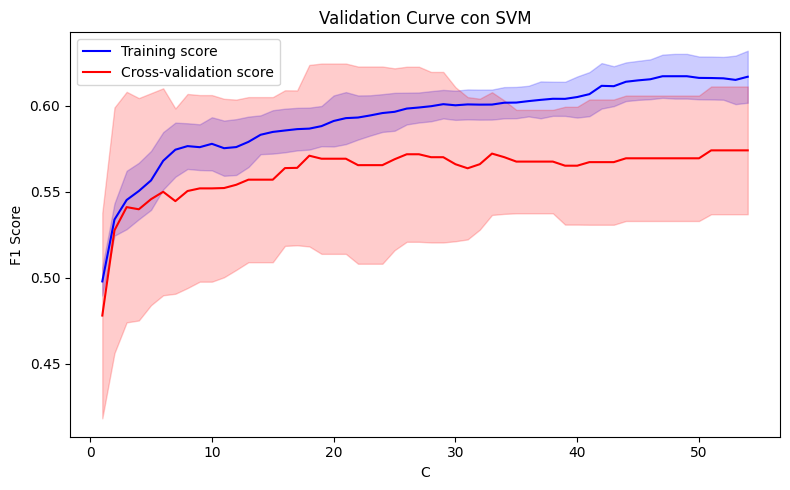

In [72]:
param_range = np.arange(1, 55)

train_scores, test_scores = validation_curve(
    SVC(kernel='poly', random_state=42),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="f1_macro")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Validation Curve con SVM")
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [73]:
svm_model = SVC(kernel='poly', C=17, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm}")

Accuracy: 0.543859649122807


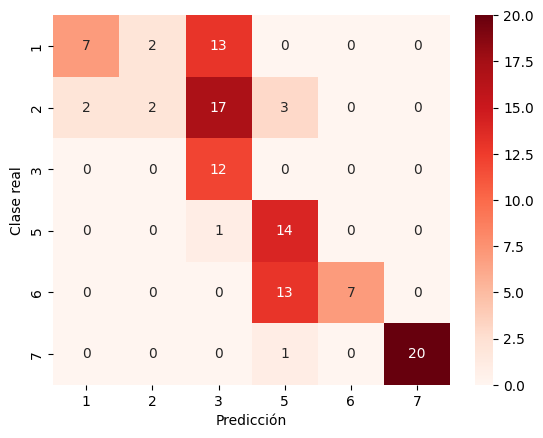

In [74]:
sns.heatmap(conf_matrix, annot=True, cmap="Reds", xticklabels=[1, 2, 3, 5, 6, 7], yticklabels=[1, 2, 3, 5, 6, 7])
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

In [75]:
print(classification_rep_svm)

              precision    recall  f1-score   support

           1       0.78      0.32      0.45        22
           2       0.50      0.08      0.14        24
           3       0.28      1.00      0.44        12
           5       0.45      0.93      0.61        15
           6       1.00      0.35      0.52        20
           7       1.00      0.95      0.98        21

    accuracy                           0.54       114
   macro avg       0.67      0.61      0.52       114
weighted avg       0.70      0.54      0.51       114



## Conclusiones y comentarios finales:

Al evaluar cada modelo con cada conjunto de datos, se llega a la conclusión que, para este dataset en específico, se pueden obtener mejores resultados usando la cantidad total de features tal cual son estructurados originalmente. Ya que aplicando PCA los resultados no son tan favorables. De hecho, se pierde bastante información, sobre todo con PCA de 2 componentes, donde la pérdida de información fue más de la mitad (50.14%). Ahora que sabemos cuál de los 3 conjuntos de datos es el mejor (el original), observamos que los mejores modelos son el **Random Forest** y **k-nn**, ya que se obtuvieron muy buenos f1, la matriz de confusión muestra que con estos modelos son donde mejor coinciden los datos, y además se consiguió accuracys alrededor del 90%. De estos 2, el mejor fue **Random Forest** con un accuracy de 92.105%.